In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import umap
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


In [2]:

# Load and initial data exploration for .xlsx file
# Load the dataset from Excel file
df = pd.read_excel('online_retail_II.xlsx') 

print("Dataset Overview:")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Dataset Overview:
Dataset shape: (525461, 8)
Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

First 5 rows:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  

Data types:
Invoice                object
Stock

In [5]:
# Data preprocessing
print("Data Preprocessing")
print("=" * 50)

# Convert InvoiceDate to datetime (already done, but let's confirm)
print(f"InvoiceDate dtype: {df['InvoiceDate'].dtype}")

# Remove cancellations (Invoice starting with 'C')
initial_count = len(df)
df = df[~df['Invoice'].astype(str).str.startswith('C')]
after_cancel_removal = len(df)

# Remove duplicates
df = df.drop_duplicates()
after_dedup = len(df)

print(f"Records after removing cancellations: {after_cancel_removal:,} ({after_cancel_removal/initial_count*100:.1f}%)")
print(f"Records after removing duplicates: {after_dedup:,} ({after_dedup/initial_count*100:.1f}%)")

# Calculate total spend per transaction (using Price column)
df['TotalSpend'] = df['Quantity'] * df['Price']

print(f"\nFinal dataset shape: {df.shape}")
print("\nSample data after preprocessing:")
print(df.head())

Data Preprocessing
InvoiceDate dtype: datetime64[ns]
Records after removing cancellations: 515,255 (98.1%)
Records after removing duplicates: 508,414 (96.8%)

Final dataset shape: (508414, 9)

Sample data after preprocessing:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  TotalSpend  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom        83.4  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom        81.0  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom        81.0  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom       1

In [6]:
# RFM Calculation
print("RFM Calculation")
print("=" * 50)

# Set reference date (one day after last transaction)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Reference date for Recency calculation: {reference_date}")

# Compute RFM per customer
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'TotalSpend': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm = rfm.dropna()

print(f"RFM dataset shape: {rfm.shape}")
print("\nFirst 10 RFM records:")
print(rfm.head(10))

RFM Calculation
Reference date for Recency calculation: 2010-12-10 20:01:00
RFM dataset shape: (4314, 4)

First 10 RFM records:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      165         11    372.86
1     12347.0        3          2   1323.32
2     12348.0       74          1    222.16
3     12349.0       43          3   2671.14
4     12351.0       11          1    300.93
5     12352.0       11          2    343.80
6     12353.0       44          1    317.76
7     12355.0      203          1    488.21
8     12356.0       16          3   3560.30
9     12357.0       24          2  12079.99


In [7]:
# Outlier handling and scaling
print("Outlier Handling and Feature Scaling")
print("=" * 50)

# Handle outliers using winsorization
def winsorize_series(series, limits=[0.05, 0.05]):
    return stats.mstats.winsorize(series, limits=limits)

rfm['Recency_w'] = winsorize_series(rfm['Recency'])
rfm['Frequency_w'] = winsorize_series(rfm['Frequency'])
rfm['Monetary_w'] = winsorize_series(rfm['Monetary'])

# Scale the features
scaler = StandardScaler()
rfm_scaled = pd.DataFrame(
    scaler.fit_transform(rfm[['Recency_w', 'Frequency_w', 'Monetary_w']]),
    columns=['Recency', 'Frequency', 'Monetary'],
    index=rfm.index
)

rfm_clean = rfm[['CustomerID']].join(rfm_scaled)

print("RFM data after outlier treatment and scaling:")
print(rfm_clean.describe())

Outlier Handling and Feature Scaling
RFM data after outlier treatment and scaling:
         CustomerID       Recency     Frequency      Monetary
count   4314.000000  4.314000e+03  4.314000e+03  4.314000e+03
mean   15348.880389  2.141181e-17 -5.352953e-17 -3.952950e-17
std     1700.930104  1.000116e+00  1.000116e+00  1.000116e+00
min    12346.000000 -9.400160e-01 -8.025859e-01 -7.821773e-01
25%    13883.250000 -7.767949e-01 -8.025859e-01 -6.585651e-01
50%    15348.500000 -3.959456e-01 -5.078923e-01 -4.137497e-01
75%    16833.750000  5.072114e-01  3.761887e-01  2.167404e-01
max    18287.000000  2.335288e+00  2.733738e+00  3.016664e+00


In [8]:
#  Descriptive Statistics
print("Part B: Exploratory Data Analysis - Descriptive Statistics")
print("=" * 60)

print("Descriptive Statistics for Original RFM Features:")
print(rfm[['Recency', 'Frequency', 'Monetary']].describe())

# Skewness analysis
print("\nSkewness Analysis:")
print(f"Recency skewness: {rfm['Recency'].skew():.2f}")
print(f"Frequency skewness: {rfm['Frequency'].skew():.2f}")
print(f"Monetary skewness: {rfm['Monetary'].skew():.2f}")

Part B: Exploratory Data Analysis - Descriptive Statistics
Descriptive Statistics for Original RFM Features:
           Recency    Frequency       Monetary
count  4314.000000  4314.000000    4314.000000
mean     91.269124     4.454103    2039.460766
std      96.943482     8.168658    8909.797773
min       1.000000     1.000000       0.000000
25%      18.000000     1.000000     307.105000
50%      53.000000     2.000000     700.405000
75%     136.000000     5.000000    1713.297500
max     374.000000   205.000000  349164.350000

Skewness Analysis:
Recency skewness: 1.28
Frequency skewness: 10.55
Monetary skewness: 24.01


Distribution Plots for RFM Features


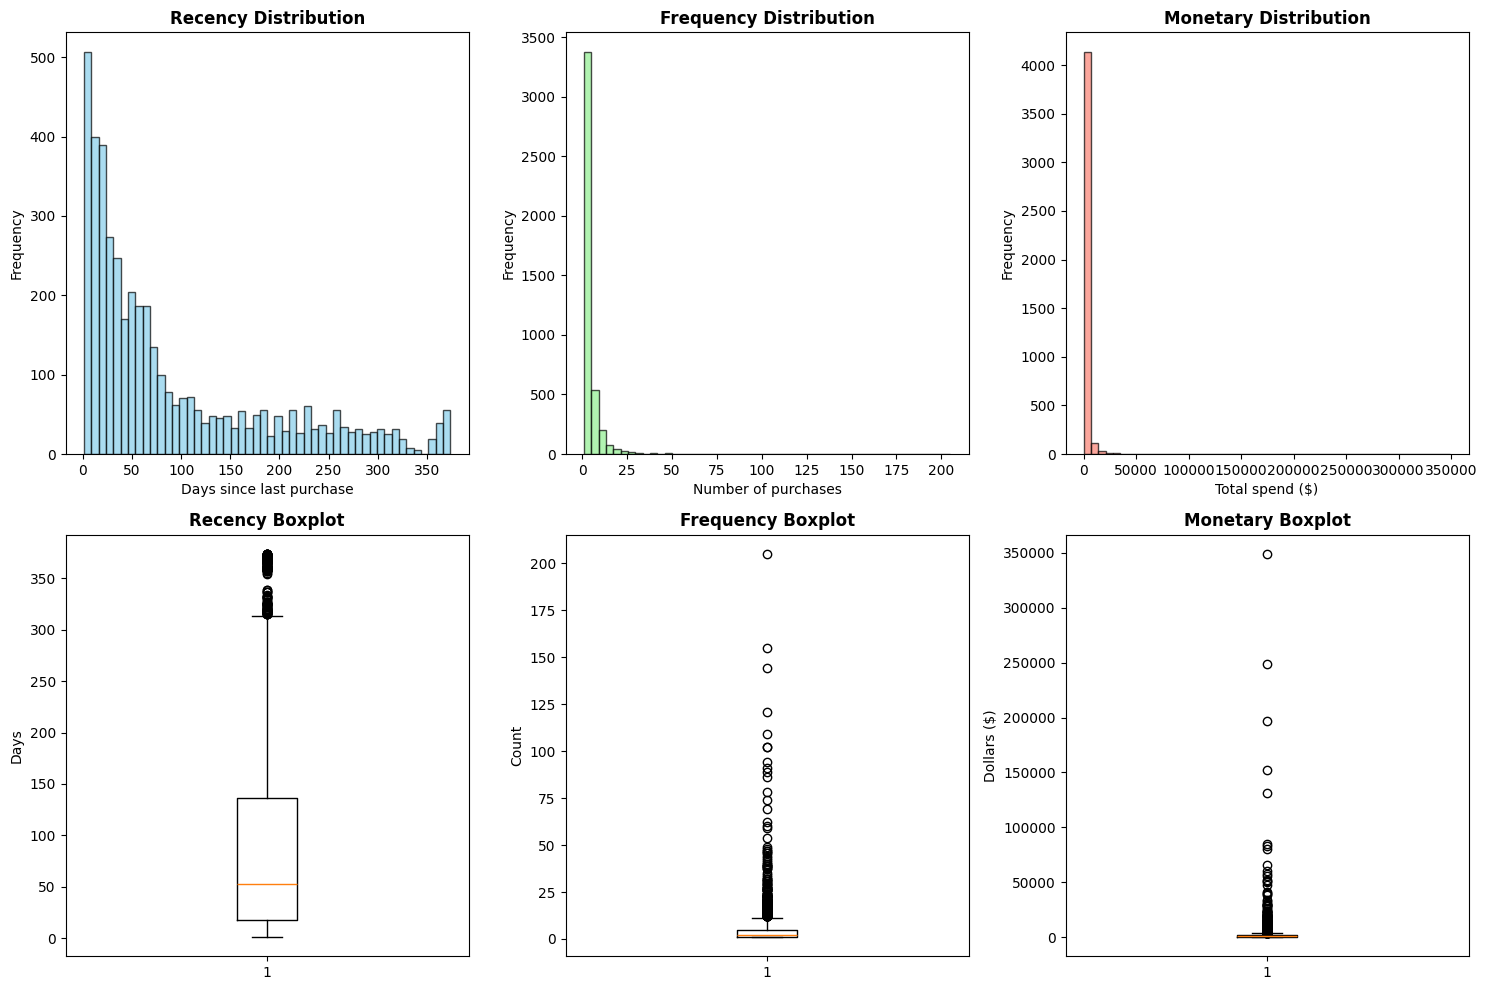

In [9]:
# Distribution Plots
print("Distribution Plots for RFM Features")
print("=" * 50)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Histograms
axes[0,0].hist(rfm['Recency'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Recency Distribution', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Days since last purchase')
axes[0,0].set_ylabel('Frequency')

axes[0,1].hist(rfm['Frequency'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Frequency Distribution', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Number of purchases')
axes[0,1].set_ylabel('Frequency')

axes[0,2].hist(rfm['Monetary'], bins=50, alpha=0.7, color='salmon', edgecolor='black')
axes[0,2].set_title('Monetary Distribution', fontsize=12, fontweight='bold')
axes[0,2].set_xlabel('Total spend ($)')
axes[0,2].set_ylabel('Frequency')

# Boxplots
axes[1,0].boxplot(rfm['Recency'])
axes[1,0].set_title('Recency Boxplot', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Days')

axes[1,1].boxplot(rfm['Frequency'])
axes[1,1].set_title('Frequency Boxplot', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Count')

axes[1,2].boxplot(rfm['Monetary'])
axes[1,2].set_title('Monetary Boxplot', fontsize=12, fontweight='bold')
axes[1,2].set_ylabel('Dollars ($)')

plt.tight_layout()
plt.show()

Correlation Analysis and Scatter Plots


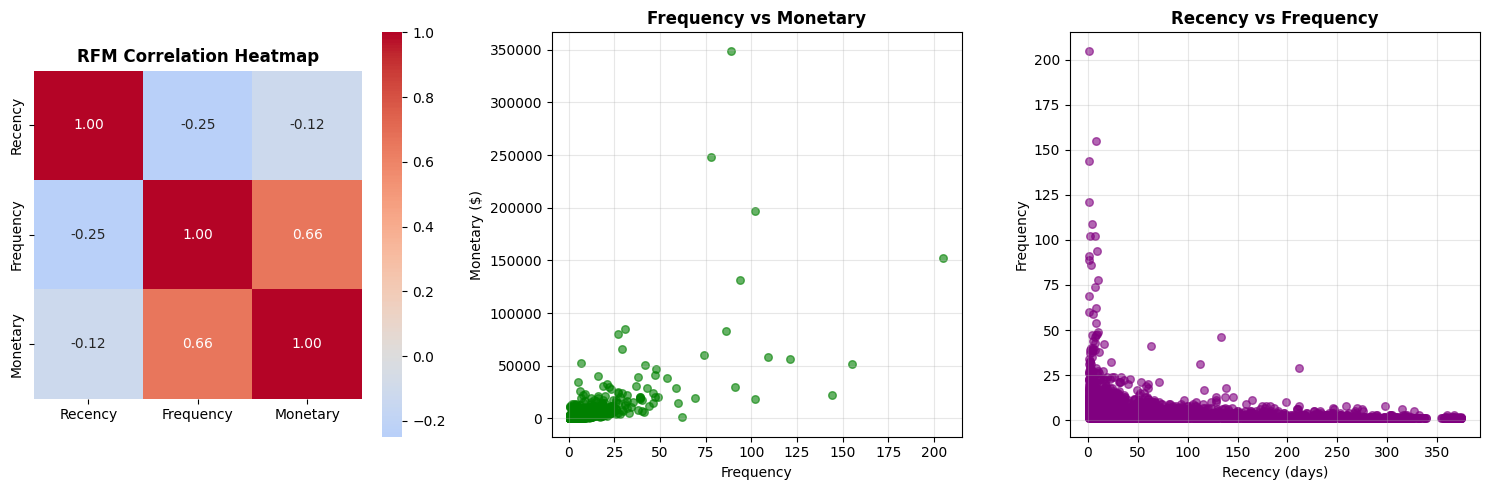

Correlation Matrix:
            Recency  Frequency  Monetary
Recency    1.000000  -0.248928 -0.120860
Frequency -0.248928   1.000000  0.655513
Monetary  -0.120860   0.655513  1.000000


In [10]:
# Correlation Analysis
print("Correlation Analysis and Scatter Plots")
print("=" * 50)

plt.figure(figsize=(15, 5))

# Correlation heatmap
plt.subplot(1, 3, 1)
correlation_matrix = rfm[['Recency', 'Frequency', 'Monetary']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('RFM Correlation Heatmap', fontweight='bold')

# Scatter plots
plt.subplot(1, 3, 2)
plt.scatter(rfm['Frequency'], rfm['Monetary'], alpha=0.6, color='green', s=30)
plt.xlabel('Frequency')
plt.ylabel('Monetary ($)')
plt.title('Frequency vs Monetary', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.scatter(rfm['Recency'], rfm['Frequency'], alpha=0.6, color='purple', s=30)
plt.xlabel('Recency (days)')
plt.ylabel('Frequency')
plt.title('Recency vs Frequency', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Correlation Matrix:")
print(correlation_matrix)

In [12]:
#  Feature Engineering
print("Part C: Feature Engineering")
print("=" * 50)

# Create a copy of the cleaned RFM data for feature engineering
rfm_enhanced = rfm_clean.copy()

print("Original RFM Statistics:")
print(rfm[['Recency', 'Frequency', 'Monetary']].describe())

# 1. Log transform for Monetary to handle skewness
print("\n1. LogMonetary Feature:")
print("-" * 30)
print("Rationale: Monetary values are typically highly right-skewed (as seen in our EDA).")
print("Log transformation helps normalize the distribution and reduce the influence of extreme values.")
rfm_enhanced['LogMonetary'] = np.log1p(rfm['Monetary'])  # log1p handles zero values safely
print(f"Original Monetary skewness: {rfm['Monetary'].skew():.2f}")
print(f"LogMonetary skewness: {rfm_enhanced['LogMonetary'].skew():.2f}")

# 2. Recency buckets based on quantiles
print("\n2. Recency_bucket Feature:")
print("-" * 30)
print("Rationale: Categorizing recency into quantile-based buckets helps create meaningful segments.")
print("This allows for easier interpretation and business rule application.")
rfm_enhanced['Recency_bucket'] = pd.qcut(rfm['Recency'], q=4, labels=['Very Recent', 'Recent', 'Less Recent', 'Not Recent'])
print("Recency bucket distribution:")
bucket_counts = rfm_enhanced['Recency_bucket'].value_counts().sort_index()
for bucket, count in bucket_counts.items():
    print(f"  {bucket}: {count} customers ({count/len(rfm_enhanced)*100:.1f}%)")

# 3. RFM Score calculation
print("\n3. RFM Score Features:")
print("-" * 30)
print("Rationale: Combining R, F, M ranks provides a comprehensive customer value score.")
print("Lower Recency is better (higher rank), while higher Frequency and Monetary are better.")

# RFM Score (lower recency is better, so we reverse the rank)
rfm_enhanced['R_rank'] = rfm_enhanced['Recency'].rank(ascending=False)  # Lower recency = higher rank
rfm_enhanced['F_rank'] = rfm_enhanced['Frequency'].rank(ascending=True)  # Higher frequency = higher rank
rfm_enhanced['M_rank'] = rfm_enhanced['Monetary'].rank(ascending=True)   # Higher monetary = higher rank

# Combined RFM score (equal weights)
rfm_enhanced['RFM_Score'] = rfm_enhanced['R_rank'] + rfm_enhanced['F_rank'] + rfm_enhanced['M_rank']

# Weighted RFM score (customizable weights - business decision)
print("Weighted RFM rationale: Recency (40%) weighted highest as it's often most predictive of future behavior.")
print("Frequency (30%) and Monetary (30%) weighted equally for engagement and value dimensions.")
rfm_enhanced['RFM_Weighted'] = (rfm_enhanced['R_rank'] * 0.4 + 
                               rfm_enhanced['F_rank'] * 0.3 + 
                               rfm_enhanced['M_rank'] * 0.3)

print("\nFeature Engineering Results:")
print("=" * 40)
print(rfm_enhanced[['Recency_bucket', 'RFM_Score', 'RFM_Weighted']].describe())

print("\nRecency Bucket Distribution:")
print(rfm_enhanced['Recency_bucket'].value_counts().sort_index())

print("\nRFM Score Correlation with Original Features:")
correlation_with_rfm = rfm_enhanced[['RFM_Score', 'Recency', 'Frequency', 'Monetary']].corr()
print(correlation_with_rfm['RFM_Score'].round(3))

# Add original monetary values for reference
rfm_enhanced['Orig_Monetary'] = rfm['Monetary']
rfm_enhanced['Orig_Frequency'] = rfm['Frequency']
rfm_enhanced['Orig_Recency'] = rfm['Recency']

print("\nSample of Enhanced RFM Data:")
print(rfm_enhanced[['Recency_bucket', 'RFM_Score', 'RFM_Weighted', 'Orig_Recency', 'Orig_Frequency', 'Orig_Monetary']].head(10))

Part C: Feature Engineering
Original RFM Statistics:
           Recency    Frequency       Monetary
count  4314.000000  4314.000000    4314.000000
mean     91.269124     4.454103    2039.460766
std      96.943482     8.168658    8909.797773
min       1.000000     1.000000       0.000000
25%      18.000000     1.000000     307.105000
50%      53.000000     2.000000     700.405000
75%     136.000000     5.000000    1713.297500
max     374.000000   205.000000  349164.350000

1. LogMonetary Feature:
------------------------------
Rationale: Monetary values are typically highly right-skewed (as seen in our EDA).
Log transformation helps normalize the distribution and reduce the influence of extreme values.
Original Monetary skewness: 24.01
LogMonetary skewness: 0.21

2. Recency_bucket Feature:
------------------------------
Rationale: Categorizing recency into quantile-based buckets helps create meaningful segments.
This allows for easier interpretation and business rule application.
Recenc

In [13]:
#  K-means Clustering - Parameter Tuning
print("Part D: Clustering Modelling & Parameter Tuning")
print("=" * 60)
print("K-means Clustering Analysis")
print("=" * 30)

# Prepare features for clustering - using the scaled RFM features
X = rfm_enhanced[['Recency', 'Frequency', 'Monetary']].values
print(f"Clustering dataset shape: {X.shape}")
print("Features used: ['Recency', 'Frequency', 'Monetary'] (scaled)")

# K-means clustering with different k values
k_range = range(2, 9)
kmeans_results = []

silhouette_scores = []
db_scores = []
inertia = []

print("\nK-means Evaluation Metrics for k = 2 to 8:")
print("k\tInertia\t\tSilhouette\tDB Index\tInterpretation")
print("-" * 70)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    
    silhouette = silhouette_score(X, kmeans_labels)
    db = davies_bouldin_score(X, kmeans_labels)
    
    silhouette_scores.append(silhouette)
    db_scores.append(db)
    inertia.append(kmeans.inertia_)
    
    kmeans_results.append({
        'k': k,
        'labels': kmeans_labels,
        'silhouette': silhouette,
        'db_index': db,
        'inertia': kmeans.inertia_
    })
    
    # Interpretation guidance
    if silhouette > 0.7:
        interpretation = "Strong structure"
    elif silhouette > 0.5:
        interpretation = "Reasonable structure"
    elif silhouette > 0.25:
        interpretation = "Weak structure"
    else:
        interpretation = "No substantial structure"
    
    print(f"{k}\t{inertia[-1]:.2f}\t\t{silhouette:.4f}\t\t{db:.4f}\t\t{interpretation}")

# Choose optimal k based on multiple criteria
print("\nOptimal k Selection Analysis:")
print("-" * 40)

# Method 1: Silhouette Score (higher is better)
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"Based on Silhouette Score: k = {optimal_k_silhouette} (score: {max(silhouette_scores):.4f})")

# Method 2: Davies-Bouldin Index (lower is better)
optimal_k_db = k_range[np.argmin(db_scores)]
print(f"Based on Davies-Bouldin Index: k = {optimal_k_db} (score: {min(db_scores):.4f})")

# Method 3: Elbow method (find the "knee" point)
inertia_diff = np.diff(inertia)
inertia_diff_ratio = inertia_diff[:-1] / inertia_diff[1:]
optimal_k_elbow = k_range[np.argmax(inertia_diff_ratio) + 1] if len(inertia_diff_ratio) > 0 else optimal_k_silhouette
print(f"Based on Elbow Method: k = {optimal_k_elbow}")

# Final decision
optimal_k = optimal_k_silhouette  # Prefer silhouette score as primary metric
print(f"\nSelected optimal k: {optimal_k}")
print("Rationale: Silhouette score is preferred for density-based cluster validation")

Part D: Clustering Modelling & Parameter Tuning
K-means Clustering Analysis
Clustering dataset shape: (4314, 3)
Features used: ['Recency', 'Frequency', 'Monetary'] (scaled)

K-means Evaluation Metrics for k = 2 to 8:
k	Inertia		Silhouette	DB Index	Interpretation
----------------------------------------------------------------------
2	6655.58		0.5145		0.8196		Reasonable structure
3	3518.54		0.5140		0.6716		Reasonable structure
4	2494.64		0.4862		0.7610		Weak structure
5	2143.78		0.4179		0.8169		Weak structure
6	1819.89		0.4010		0.9046		Weak structure
7	1502.94		0.4135		0.8576		Weak structure
8	1350.51		0.3821		0.9015		Weak structure

Optimal k Selection Analysis:
----------------------------------------
Based on Silhouette Score: k = 2 (score: 0.5145)
Based on Davies-Bouldin Index: k = 3 (score: 0.6716)
Based on Elbow Method: k = 3

Selected optimal k: 2
Rationale: Silhouette score is preferred for density-based cluster validation


K-means Evaluation Plots


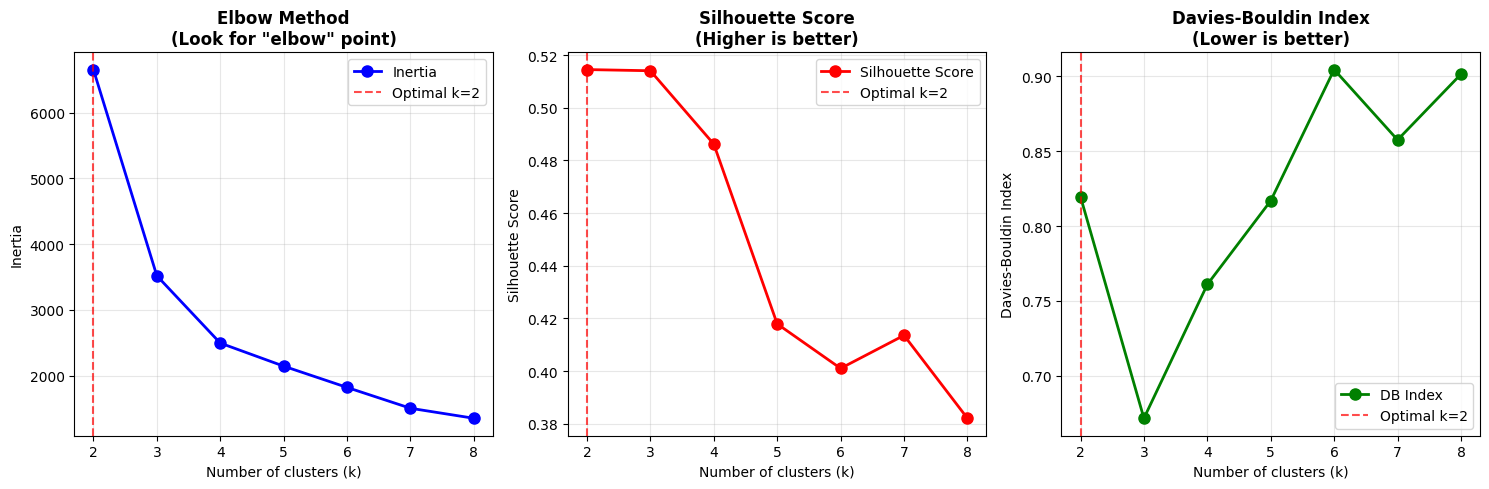


Cluster Quality Interpretation:
Silhouette Score Guidelines:
  0.71 - 1.00: Strong structure found
  0.51 - 0.70: Reasonable structure
  0.26 - 0.50: Weak or artificial structure
  0.00 - 0.25: No substantial structure

Best Silhouette Score: 0.5145 (k=2)

Davies-Bouldin Index Guidelines:
  Lower values indicate better clustering
  < 0.5: Excellent separation
  0.5 - 1.0: Good separation
  > 1.0: Poor separation
Best DB Index: 0.6716 (k=3)


In [14]:
# K-means Evaluation Plots
print("K-means Evaluation Plots")
print("=" * 40)

plt.figure(figsize=(15, 5))

# Elbow plot
plt.subplot(1, 3, 1)
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8, label='Inertia')
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method\n(Look for "elbow" point)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Silhouette score plot
plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8, label='Silhouette Score')
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score\n(Higher is better)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Davies-Bouldin index plot
plt.subplot(1, 3, 3)
plt.plot(k_range, db_scores, 'go-', linewidth=2, markersize=8, label='DB Index')
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index\n(Lower is better)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed interpretation
print("\nCluster Quality Interpretation:")
print("=" * 35)
print("Silhouette Score Guidelines:")
print("  0.71 - 1.00: Strong structure found")
print("  0.51 - 0.70: Reasonable structure")
print("  0.26 - 0.50: Weak or artificial structure")
print("  0.00 - 0.25: No substantial structure")
print(f"\nBest Silhouette Score: {max(silhouette_scores):.4f} (k={optimal_k_silhouette})")

print("\nDavies-Bouldin Index Guidelines:")
print("  Lower values indicate better clustering")
print("  < 0.5: Excellent separation")
print("  0.5 - 1.0: Good separation") 
print("  > 1.0: Poor separation")
print(f"Best DB Index: {min(db_scores):.4f} (k={optimal_k_db})")

In [15]:
# Final K-means Clustering
print("Final K-means Clustering")
print("=" * 40)

# Final K-means with optimal k
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_enhanced['KMeans_Cluster'] = final_kmeans.fit_predict(X)

# Calculate final metrics
final_silhouette = silhouette_score(X, rfm_enhanced['KMeans_Cluster'])
final_db = davies_bouldin_score(X, rfm_enhanced['KMeans_Cluster'])

print(f"K-means clustering completed with k={optimal_k}")
print(f"Final Silhouette Score: {final_silhouette:.4f}")
print(f"Final Davies-Bouldin Index: {final_db:.4f}")

print("\nCluster Distribution:")
print("-" * 25)
cluster_counts = rfm_enhanced['KMeans_Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = count/len(rfm_enhanced)*100
    print(f"Cluster {cluster}: {count} customers ({percentage:.1f}%)")

print(f"\nTotal customers clustered: {len(rfm_enhanced)}")

Final K-means Clustering
K-means clustering completed with k=2
Final Silhouette Score: 0.5145
Final Davies-Bouldin Index: 0.8196

Cluster Distribution:
-------------------------
Cluster 0: 3403 customers (78.9%)
Cluster 1: 911 customers (21.1%)

Total customers clustered: 4314


DBSCAN Clustering - Parameter Selection
Step 1: K-distance Plot for Epsilon (eps) Selection
---------------------------------------------


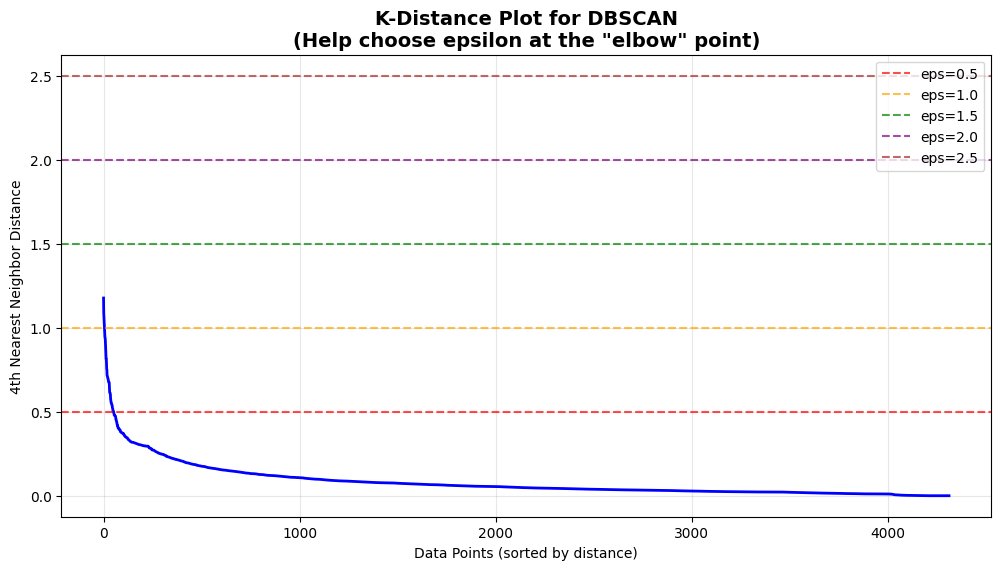

Epsilon Selection Guidance:
• Look for the 'elbow' point where the curve starts to flatten
• This indicates the optimal epsilon for DBSCAN
• Points above the elbow are likely noise
• Suggested epsilon values to try: [0.5, 1.0, 1.5, 2.0, 2.5]


In [16]:
#  DBSCAN Clustering - Parameter Selection
print("DBSCAN Clustering - Parameter Selection")
print("=" * 50)
print("Step 1: K-distance Plot for Epsilon (eps) Selection")
print("-" * 45)

# K-distance plot for epsilon selection using 4th nearest neighbor
nn = NearestNeighbors(n_neighbors=4)
nn.fit(X)
distances, indices = nn.kneighbors(X)

# Plot k-distance graph (using 4th nearest neighbor)
k_dist = np.sort(distances[:, 3])[::-1]  # 4th nearest neighbor distances

plt.figure(figsize=(12, 6))
plt.plot(k_dist, linewidth=2, color='blue')
plt.xlabel('Data Points (sorted by distance)')
plt.ylabel('4th Nearest Neighbor Distance')
plt.title('K-Distance Plot for DBSCAN\n(Help choose epsilon at the "elbow" point)', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)

# Mark potential epsilon values at potential elbow points
potential_eps = [0.5, 1.0, 1.5, 2.0, 2.5]
colors = ['red', 'orange', 'green', 'purple', 'brown']
for i, eps in enumerate(potential_eps):
    plt.axhline(y=eps, color=colors[i], linestyle='--', alpha=0.7, label=f'eps={eps}')

plt.legend()
plt.show()

print("Epsilon Selection Guidance:")
print("• Look for the 'elbow' point where the curve starts to flatten")
print("• This indicates the optimal epsilon for DBSCAN")
print("• Points above the elbow are likely noise")
print("• Suggested epsilon values to try:", potential_eps)

In [17]:
# DBSCAN Parameter Tuning Results
print("DBSCAN Parameter Tuning Results")
print("=" * 50)
print("Testing eps values with min_samples from 4 to 8")
print("-" * 45)

# Try different DBSCAN parameters
dbscan_results = []
min_samples_range = range(4, 9)
eps_values = [0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 2.0]

best_dbscan = None
best_silhouette = -1
best_params = None

print("eps\tmin_samples\tclusters\tnoise\t\tnoise%\tsilhouette\tQuality")
print("-" * 85)

for min_samples in min_samples_range:
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X)
        
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        noise_percent = (n_noise / len(dbscan_labels)) * 100
        
        # Calculate silhouette score (excluding noise points for calculation)
        silhouette = -1
        quality = "Invalid"
        if n_clusters > 1:
            non_noise_mask = dbscan_labels != -1
            if sum(non_noise_mask) > 1:
                silhouette = silhouette_score(X[non_noise_mask], dbscan_labels[non_noise_mask])
                if silhouette > 0.7:
                    quality = "Excellent"
                elif silhouette > 0.5:
                    quality = "Good"
                elif silhouette > 0.25:
                    quality = "Fair"
                else:
                    quality = "Poor"
            else:
                quality = "Single cluster"
        else:
            quality = "No clusters"
            
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_percent': noise_percent,
            'silhouette': silhouette
        })
        
        if silhouette > best_silhouette and n_clusters >= 2 and n_clusters <= 10:
            best_silhouette = silhouette
            best_dbscan = dbscan_labels
            best_params = {'eps': eps, 'min_samples': min_samples}
            
        print(f"{eps}\t{min_samples}\t\t{n_clusters}\t\t{n_noise}\t\t{noise_percent:.1f}%\t{silhouette:.4f}\t{quality}")

# Display best parameters
print(f"\nBest DBSCAN parameters found:")
print(f"  eps: {best_params['eps']}")
print(f"  min_samples: {best_params['min_samples']}")
print(f"  Clusters: {len(set(best_dbscan)) - (1 if -1 in best_dbscan else 0)}")
print(f"  Noise points: {list(best_dbscan).count(-1)} ({list(best_dbscan).count(-1)/len(best_dbscan)*100:.1f}%)")
print(f"  Silhouette score: {best_silhouette:.4f}")

# Analyze parameter sensitivity
dbscan_df = pd.DataFrame(dbscan_results)
print(f"\nParameter Sensitivity Analysis:")
print(f"Average clusters across all parameters: {dbscan_df['n_clusters'].mean():.1f}")
print(f"Average noise percentage: {dbscan_df['noise_percent'].mean():.1f}%")
print(f"Best silhouette score: {dbscan_df['silhouette'].max():.4f}")

DBSCAN Parameter Tuning Results
Testing eps values with min_samples from 4 to 8
---------------------------------------------
eps	min_samples	clusters	noise		noise%	silhouette	Quality
-------------------------------------------------------------------------------------
0.3	4		2		133		3.1%	0.4054	Fair
0.5	4		2		36		0.8%	0.4755	Fair
0.7	4		1		19		0.4%	-1.0000	No clusters
0.9	4		1		1		0.0%	-1.0000	No clusters
1.1	4		1		0		0.0%	-1.0000	No clusters
1.3	4		1		0		0.0%	-1.0000	No clusters
1.5	4		1		0		0.0%	-1.0000	No clusters
1.7	4		1		0		0.0%	-1.0000	No clusters
2.0	4		1		0		0.0%	-1.0000	No clusters
0.3	5		6		165		3.8%	-0.1312	Poor
0.5	5		1		42		1.0%	-1.0000	No clusters
0.7	5		2		19		0.4%	0.4678	Fair
0.9	5		2		1		0.0%	0.4678	Fair
1.1	5		1		0		0.0%	-1.0000	No clusters
1.3	5		1		0		0.0%	-1.0000	No clusters
1.5	5		1		0		0.0%	-1.0000	No clusters
1.7	5		1		0		0.0%	-1.0000	No clusters
2.0	5		1		0		0.0%	-1.0000	No clusters
0.3	6		2		201		4.7%	0.4125	Fair
0.5	6		1		46		1.1%	-1.0000	No clusters
0.7	6	

In [18]:
# Applying Final DBSCAN Clustering
print("Applying Final DBSCAN Clustering")
print("=" * 45)

# Apply best DBSCAN parameters
final_dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
rfm_enhanced['DBSCAN_Cluster'] = final_dbscan.fit_predict(X)

# Calculate DBSCAN metrics
dbscan_non_noise = rfm_enhanced[rfm_enhanced['DBSCAN_Cluster'] != -1]
dbscan_silhouette = silhouette_score(dbscan_non_noise[['Recency', 'Frequency', 'Monetary']], 
                                   dbscan_non_noise['DBSCAN_Cluster'])
dbscan_db = davies_bouldin_score(dbscan_non_noise[['Recency', 'Frequency', 'Monetary']], 
                               dbscan_non_noise['DBSCAN_Cluster'])

print("DBSCAN Results Summary:")
print("=" * 25)
print(f"Parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
print(f"Silhouette Score (excluding noise): {dbscan_silhouette:.4f}")
print(f"Davies-Bouldin Index (excluding noise): {dbscan_db:.4f}")

print("\nDBSCAN Cluster Distribution:")
print("-" * 30)
dbscan_counts = rfm_enhanced['DBSCAN_Cluster'].value_counts().sort_index()
total_customers = len(rfm_enhanced)

for cluster, count in dbscan_counts.items():
    cluster_name = "Noise" if cluster == -1 else f"Cluster {cluster}"
    percentage = count/total_customers*100
    print(f"{cluster_name}: {count} customers ({percentage:.1f}%)")

noise_count = dbscan_counts.get(-1, 0)
clustered_count = total_customers - noise_count
print(f"\nSummary:")
print(f"Total customers: {total_customers}")
print(f"Successfully clustered: {clustered_count} ({clustered_count/total_customers*100:.1f}%)")
print(f"Noise/Outliers: {noise_count} ({noise_count/total_customers*100:.1f}%)")
print(f"Number of clusters found: {len(dbscan_counts) - (1 if -1 in dbscan_counts else 0)}")

# Compare with K-means
print(f"\nComparison with K-means:")
print(f"K-means clusters: {optimal_k}")
print(f"K-means silhouette: {final_silhouette:.4f}")
print(f"DBSCAN clusters: {len(dbscan_counts) - (1 if -1 in dbscan_counts else 0)}")
print(f"DBSCAN silhouette: {dbscan_silhouette:.4f}")

Applying Final DBSCAN Clustering
DBSCAN Results Summary:
Parameters: eps=0.5, min_samples=4
Silhouette Score (excluding noise): 0.4755
Davies-Bouldin Index (excluding noise): 0.4845

DBSCAN Cluster Distribution:
------------------------------
Noise: 36 customers (0.8%)
Cluster 0: 4274 customers (99.1%)
Cluster 1: 4 customers (0.1%)

Summary:
Total customers: 4314
Successfully clustered: 4278 (99.2%)
Noise/Outliers: 36 (0.8%)
Number of clusters found: 2

Comparison with K-means:
K-means clusters: 2
K-means silhouette: 0.5145
DBSCAN clusters: 2
DBSCAN silhouette: 0.4755


In [19]:
# Cluster Profiles - K-means
print("Part E: Second EDA & Statistical Inference")
print("=" * 60)
print("K-means Cluster Profiles")
print("=" * 30)

# Detailed cluster profiles for K-means
kmeans_profiles = rfm_enhanced.groupby('KMeans_Cluster').agg({
    'Orig_Recency': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'Orig_Frequency': ['mean', 'median', 'std', 'min', 'max'],
    'Orig_Monetary': ['mean', 'median', 'std', 'min', 'max'],
    'RFM_Score': ['mean', 'median', 'std'],
    'RFM_Weighted': ['mean', 'median']
}).round(2)

# Flatten column names for better readability
kmeans_profiles.columns = ['_'.join(col).strip() for col in kmeans_profiles.columns.values]
kmeans_profiles = kmeans_profiles.rename(columns={'Orig_Recency_count': 'Count'})

print("K-means Cluster Profiles (Detailed Statistics):")
print("=" * 50)
print(kmeans_profiles)

# Create a simplified profile for easier interpretation
print("\nSimplified K-means Cluster Profiles:")
print("=" * 40)
simple_kmeans_profiles = rfm_enhanced.groupby('KMeans_Cluster').agg({
    'Orig_Recency': ['mean', 'median'],
    'Orig_Frequency': ['mean', 'median'],
    'Orig_Monetary': ['mean', 'median'],
    'RFM_Score': 'mean',
    'RFM_Weighted': 'mean'
}).round(2)

simple_kmeans_profiles.columns = ['Recency_Mean', 'Recency_Median', 'Frequency_Mean', 'Frequency_Median', 
                                 'Monetary_Mean', 'Monetary_Median', 'RFM_Score_Mean', 'RFM_Weighted_Mean']

# Add cluster size
cluster_sizes = rfm_enhanced['KMeans_Cluster'].value_counts().sort_index()
simple_kmeans_profiles['Size'] = cluster_sizes
simple_kmeans_profiles['Size_Percent'] = (cluster_sizes / len(rfm_enhanced) * 100).round(1)

print(simple_kmeans_profiles)

# Interpret each cluster
print("\nK-means Cluster Interpretation:")
print("=" * 35)
for cluster in sorted(rfm_enhanced['KMeans_Cluster'].unique()):
    cluster_data = rfm_enhanced[rfm_enhanced['KMeans_Cluster'] == cluster]
    size = len(cluster_data)
    size_pct = (size / len(rfm_enhanced)) * 100
    
    recency_mean = cluster_data['Orig_Recency'].mean()
    frequency_mean = cluster_data['Orig_Frequency'].mean()
    monetary_mean = cluster_data['Orig_Monetary'].mean()
    rfm_score_mean = cluster_data['RFM_Score'].mean()
    
    print(f"\nCluster {cluster} ({size} customers, {size_pct:.1f}%):")
    print(f"  Recency: {recency_mean:.1f} days (since last purchase)")
    print(f"  Frequency: {frequency_mean:.1f} purchases")
    print(f"  Monetary: ${monetary_mean:.2f} total spend")
    print(f"  RFM Score: {rfm_score_mean:.1f} (higher = better)")
    
    # Characterize the cluster
    if recency_mean < 50 and frequency_mean > 5 and monetary_mean > 500:
        print("  Type: VIP Customers")
    elif recency_mean < 30 and frequency_mean < 3 and monetary_mean > 200:
        print("  Type: High Value New Customers")
    elif recency_mean > 100 and frequency_mean > 3:
        print("  Type: At-Risk Loyal Customers")
    elif recency_mean < 60 and monetary_mean < 100:
        print("  Type: Low Value Active Customers")
    else:
        print("  Type: Mixed Profile")

Part E: Second EDA & Statistical Inference
K-means Cluster Profiles
K-means Cluster Profiles (Detailed Statistics):
                Count  Orig_Recency_mean  Orig_Recency_median  \
KMeans_Cluster                                                  
0                3403             108.25                 67.0   
1                 911              27.85                 15.0   

                Orig_Recency_std  Orig_Recency_min  Orig_Recency_max  \
KMeans_Cluster                                                         
0                         100.80                 1               374   
1                          38.09                 1               327   

                Orig_Frequency_mean  Orig_Frequency_median  \
KMeans_Cluster                                               
0                              2.28                    2.0   
1                             12.59                    9.0   

                Orig_Frequency_std  Orig_Frequency_min  ...  \
KMeans_Cluster        

In [20]:
# Cluster Profiles - DBSCAN
print("\nDBSCAN Cluster Profiles (including noise as cluster -1)")
print("=" * 55)

# Detailed cluster profiles for DBSCAN
dbscan_profiles = rfm_enhanced.groupby('DBSCAN_Cluster').agg({
    'Orig_Recency': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'Orig_Frequency': ['mean', 'median', 'std', 'min', 'max'],
    'Orig_Monetary': ['mean', 'median', 'std', 'min', 'max'],
    'RFM_Score': ['mean', 'median', 'std'],
    'RFM_Weighted': ['mean', 'median']
}).round(2)

# Flatten column names
dbscan_profiles.columns = ['_'.join(col).strip() for col in dbscan_profiles.columns.values]
dbscan_profiles = dbscan_profiles.rename(columns={'Orig_Recency_count': 'Count'})

print("DBSCAN Cluster Profiles (Detailed Statistics):")
print("=" * 50)
print(dbscan_profiles)

# Create a simplified profile for easier interpretation
print("\nSimplified DBSCAN Cluster Profiles:")
print("=" * 40)
simple_dbscan_profiles = rfm_enhanced.groupby('DBSCAN_Cluster').agg({
    'Orig_Recency': ['mean', 'median'],
    'Orig_Frequency': ['mean', 'median'],
    'Orig_Monetary': ['mean', 'median'],
    'RFM_Score': 'mean',
    'RFM_Weighted': 'mean'
}).round(2)

simple_dbscan_profiles.columns = ['Recency_Mean', 'Recency_Median', 'Frequency_Mean', 'Frequency_Median', 
                                 'Monetary_Mean', 'Monetary_Median', 'RFM_Score_Mean', 'RFM_Weighted_Mean']

# Add cluster size
dbscan_sizes = rfm_enhanced['DBSCAN_Cluster'].value_counts().sort_index()
simple_dbscan_profiles['Size'] = dbscan_sizes
simple_dbscan_profiles['Size_Percent'] = (dbscan_sizes / len(rfm_enhanced) * 100).round(1)

print(simple_dbscan_profiles)

# Interpret each DBSCAN cluster (including noise)
print("\nDBSCAN Cluster Interpretation:")
print("=" * 35)
for cluster in sorted(rfm_enhanced['DBSCAN_Cluster'].unique()):
    cluster_data = rfm_enhanced[rfm_enhanced['DBSCAN_Cluster'] == cluster]
    size = len(cluster_data)
    size_pct = (size / len(rfm_enhanced)) * 100
    
    recency_mean = cluster_data['Orig_Recency'].mean()
    frequency_mean = cluster_data['Orig_Frequency'].mean()
    monetary_mean = cluster_data['Orig_Monetary'].mean()
    rfm_score_mean = cluster_data['RFM_Score'].mean()
    
    if cluster == -1:
        print(f"\nNoise/Outliers ({size} customers, {size_pct:.1f}%):")
        print(f"  Recency: {recency_mean:.1f} days")
        print(f"  Frequency: {frequency_mean:.1f} purchases")
        print(f"  Monetary: ${monetary_mean:.2f} total spend")
        print(f"  RFM Score: {rfm_score_mean:.1f}")
        print("  Type: Anomalies - require individual investigation")
    else:
        print(f"\nCluster {cluster} ({size} customers, {size_pct:.1f}%):")
        print(f"  Recency: {recency_mean:.1f} days")
        print(f"  Frequency: {frequency_mean:.1f} purchases")
        print(f"  Monetary: ${monetary_mean:.2f} total spend")
        print(f"  RFM Score: {rfm_score_mean:.1f}")
        
        # Characterize DBSCAN clusters
        if monetary_mean > 1000:
            print("  Type: High-Value Segment")
        elif frequency_mean > 8:
            print("  Type: Frequent Buyers")
        elif recency_mean < 30:
            print("  Type: Recent Customers")
        else:
            print("  Type: General Segment")


DBSCAN Cluster Profiles (including noise as cluster -1)
DBSCAN Cluster Profiles (Detailed Statistics):
                Count  Orig_Recency_mean  Orig_Recency_median  \
DBSCAN_Cluster                                                  
-1                 36             177.06                176.0   
 0               4274              90.39                 52.0   
 1                  4             262.50                264.0   

                Orig_Recency_std  Orig_Recency_min  Orig_Recency_max  \
DBSCAN_Cluster                                                         
-1                         78.61                36               327   
 0                         96.67                 1               374   
 1                         23.80               232               290   

                Orig_Frequency_mean  Orig_Frequency_median  \
DBSCAN_Cluster                                               
-1                             9.47                    8.0   
 0                     

In [22]:
# Statistical Significance Testing
print("Statistical Significance Testing")
print("=" * 50)
print("Testing whether clusters differ significantly on Monetary value")
print("-" * 60)

from scipy.stats import f_oneway, kruskal

print("1. K-means Clusters - Monetary Value Differences:")
print("-" * 45)

# Prepare data for K-means statistical tests
kmeans_clusters_monetary = []
for cluster in sorted(rfm_enhanced['KMeans_Cluster'].unique()):
    cluster_data = rfm_enhanced[rfm_enhanced['KMeans_Cluster'] == cluster]['Orig_Monetary']
    kmeans_clusters_monetary.append(cluster_data)
    print(f"  Cluster {cluster}: n={len(cluster_data)}, mean=${cluster_data.mean():.2f}, std=${cluster_data.std():.2f}")

# ANOVA test (parametric)
f_stat_anova, p_value_anova = f_oneway(*kmeans_clusters_monetary)
print(f"\nANOVA Test Results:")
print(f"  F-statistic: {f_stat_anova:.4f}")
print(f"  p-value: {p_value_anova:.6f}")
print(f"  Interpretation: {'SIGNIFICANT difference' if p_value_anova < 0.05 else 'NO significant difference'} between clusters")

# Kruskal-Wallis test (non-parametric)
h_stat_kw, p_value_kw = kruskal(*kmeans_clusters_monetary)
print(f"\nKruskal-Wallis Test Results:")
print(f"  H-statistic: {h_stat_kw:.4f}")
print(f"  p-value: {p_value_kw:.6f}")
print(f"  Interpretation: {'SIGNIFICANT difference' if p_value_kw < 0.05 else 'NO significant difference'} between clusters")

print("\n2. DBSCAN Clusters - Monetary Value Differences (excluding noise):")
print("-" * 65)

# Prepare data for DBSCAN statistical tests (excluding noise)
dbscan_clusters_monetary = []
valid_clusters = []

for cluster in sorted(rfm_enhanced['DBSCAN_Cluster'].unique()):
    if cluster != -1:  # Exclude noise
        cluster_data = rfm_enhanced[rfm_enhanced['DBSCAN_Cluster'] == cluster]['Orig_Monetary']
        dbscan_clusters_monetary.append(cluster_data)
        valid_clusters.append(cluster)
        print(f"  Cluster {cluster}: n={len(cluster_data)}, mean=${cluster_data.mean():.2f}, std=${cluster_data.std():.2f}")

if len(dbscan_clusters_monetary) > 1:
    # ANOVA test for DBSCAN
    f_stat_anova_db, p_value_anova_db = f_oneway(*dbscan_clusters_monetary)
    print(f"\nANOVA Test Results (DBSCAN clusters):")
    print(f"  F-statistic: {f_stat_anova_db:.4f}")
    print(f"  p-value: {p_value_anova_db:.6f}")
    print(f"  Interpretation: {'SIGNIFICANT difference' if p_value_anova_db < 0.05 else 'NO significant difference'}")

    # Kruskal-Wallis test for DBSCAN
    h_stat_kw_db, p_value_kw_db = kruskal(*dbscan_clusters_monetary)
    print(f"\nKruskal-Wallis Test Results (DBSCAN clusters):")
    print(f"  H-statistic: {h_stat_kw_db:.4f}")
    print(f"  p-value: {p_value_kw_db:.6f}")
    print(f"  Interpretation: {'SIGNIFICANT difference' if p_value_kw_db < 0.05 else 'NO significant difference'}")
else:
    print("\nNot enough clusters for statistical testing (need at least 2 clusters)")

# Statistical conclusion
print("\n" + "=" * 70)
print("STATISTICAL INFERENCE CONCLUSION:")
print("=" * 70)
if p_value_anova < 0.05:
    print(" K-means clustering successfully identifies groups with significantly different Monetary values")
    print(f"  (p-value: {p_value_anova:.6f} < 0.05)")
else:
    print(" K-means clustering does not identify significantly different Monetary value groups")
    print(f"  (p-value: {p_value_anova:.6f} >= 0.05)")

if len(dbscan_clusters_monetary) > 1 and p_value_anova_db < 0.05:
    print(" DBSCAN clustering successfully identifies groups with significantly different Monetary values")
    print(f"  (p-value: {p_value_anova_db:.6f} < 0.05)")
elif len(dbscan_clusters_monetary) > 1:
    print(" DBSCAN clustering does not identify significantly different Monetary value groups")
    print(f"  (p-value: {p_value_anova_db:.6f} >= 0.05)")

Statistical Significance Testing
Testing whether clusters differ significantly on Monetary value
------------------------------------------------------------
1. K-means Clusters - Monetary Value Differences:
---------------------------------------------
  Cluster 0: n=3403, mean=$687.90, std=$598.62
  Cluster 1: n=911, mean=$7088.17, std=$18508.36

ANOVA Test Results:
  F-statistic: 405.6053
  p-value: 0.000000
  Interpretation: SIGNIFICANT difference between clusters

Kruskal-Wallis Test Results:
  H-statistic: 2001.9369
  p-value: 0.000000
  Interpretation: SIGNIFICANT difference between clusters

2. DBSCAN Clusters - Monetary Value Differences (excluding noise):
-----------------------------------------------------------------
  Cluster 0: n=4274, mean=$2001.26, std=$8920.21
  Cluster 1: n=4, mean=$10129.21, std=$3239.30

ANOVA Test Results (DBSCAN clusters):
  F-statistic: 3.3199
  p-value: 0.068514
  Interpretation: NO significant difference

Kruskal-Wallis Test Results (DBSCAN cl

In [23]:
#  Business Action Recommendations
print("Business Action Recommendations")
print("=" * 50)
print("Based on Cluster Analysis - Actionable Strategies")
print("=" * 45)

def propose_business_actions(cluster_df, method_name):
    print(f"\n{method_name} CLUSTERS - BUSINESS ACTIONS:")
    print("=" * 50)
    
    for cluster_id in sorted(cluster_df['KMeans_Cluster' if method_name == 'K-means' else 'DBSCAN_Cluster'].unique()):
        if method_name == 'DBSCAN' and cluster_id == -1:
            cluster_name = "NOISE/OUTLIERS"
            is_noise = True
        else:
            cluster_name = f"CLUSTER {cluster_id}"
            is_noise = False
            
        cluster_data = cluster_df[cluster_df['KMeans_Cluster' if method_name == 'K-means' else 'DBSCAN_Cluster'] == cluster_id]
        
        avg_recency = cluster_data['Orig_Recency'].mean()
        avg_frequency = cluster_data['Orig_Frequency'].mean()
        avg_monetary = cluster_data['Orig_Monetary'].mean()
        size = len(cluster_data)
        size_pct = (size / len(cluster_df)) * 100
        
        print(f"\n{cluster_name} - {size} customers ({size_pct:.1f}% of base):")
        print(f"  Profile: Recency={avg_recency:.1f} days, Frequency={avg_frequency:.1f}, Monetary=${avg_monetary:.2f}")
        print("-" * 60)
        
        if is_noise:
            print("   PRIMARY ACTION: INVESTIGATE & PERSONALIZE")
            print("  • Conduct manual review of each customer in this group")
            print("  • Could contain rare high-value customers needing VIP treatment")
            print("  • Check for data quality issues or special cases")
            print("  • Consider one-on-one outreach for relationship building")
            
        elif avg_recency < 30 and avg_frequency > 8 and avg_monetary > 1000:
            print("   PRIMARY ACTION: VIP RETENTION PROGRAM")
            print("  • Assign dedicated account managers")
            print("  • Offer exclusive early access to new products")
            print("  • Invite to VIP events and previews")
            print("  • Provide premium customer support")
            print("  • Goal: Maintain loyalty and increase lifetime value")
            
        elif avg_recency < 60 and avg_frequency < 3 and avg_monetary > 500:
            print("   PRIMARY ACTION: LOYALTY BUILDING CAMPAIGN")
            print("  • Welcome series with educational content")
            print("  • Frequency-based rewards program")
            print("  • Personalized product recommendations")
            print("  • Cross-selling of complementary products")
            print("  • Goal: Increase purchase frequency")
            
        elif avg_recency > 90 and avg_frequency > 5:
            print("   PRIMARY ACTION: WIN-BACK CAMPAIGN")
            print("  • \"We miss you\" personalized email series")
            print("  • Special reactivation discounts (25-30% off)")
            print("  • Survey to understand reasons for leaving")
            print("  • Highlight new products or improvements")
            print("  • Goal: Reactivate dormant valuable customers")
            
        elif avg_recency < 45 and avg_monetary < 100:
            print("   PRIMARY ACTION: UPSELL & EDUCATION")
            print("  • Educational content on product benefits")
            print("  • Bundle offers for increased value")
            print("  • Introduce premium product lines")
            print("  • Volume discount incentives")
            print("  • Goal: Increase average order value")
            
        elif avg_recency > 120:
            print("   PRIMARY ACTION: RE-ENGAGEMENT NURTURING")
            print("  • Regular newsletter with valuable content")
            print("  • Seasonal promotions and limited-time offers")
            print("  • Social media retargeting campaigns")
            print("  • Customer satisfaction surveys")
            print("  • Goal: Bring back to active status")
            
        else:
            print("   PRIMARY ACTION: GENERAL NURTURING & OPTIMIZATION")
            print("  • Regular promotional communications")
            print("  • Loyalty point accumulation program")
            print("  • Seasonal and holiday campaigns")
            print("  • A/B test different engagement strategies")
            print("  • Goal: Maintain engagement and identify upsell opportunities")
        
        # Additional metrics for decision making
        print(f"\n   ADDITIONAL INSIGHTS:")
        print(f"  • Cluster represents ${(avg_monetary * size):,.0f} in potential revenue")
        print(f"  • Average customer value: ${avg_monetary:.2f}")
        print(f"  • Engagement level: {'High' if avg_frequency > 5 else 'Medium' if avg_frequency > 2 else 'Low'}")
        print(f"  • Recency status: {'Recent' if avg_recency < 30 else 'Active' if avg_recency < 90 else 'Dormant'}")

# Apply to both clustering methods
propose_business_actions(rfm_enhanced, 'K-means')
propose_business_actions(rfm_enhanced, 'DBSCAN')

print("\n" + "=" * 70)
print("SUMMARY OF KEY BUSINESS RECOMMENDATIONS:")
print("=" * 70)
print("1. PRIORITIZE clusters with high monetary value and recent activity for retention")
print("2. DEVELOP targeted win-back campaigns for dormant high-frequency customers") 
print("3. INVESTIGATE noise points - may contain valuable outliers or data issues")
print("4. IMPLEMENT tiered loyalty programs based on cluster characteristics")
print("5. ALLOCATE marketing budget proportionally to cluster value and size")
print("6. MONITOR cluster migration over time to detect changing customer behavior")

Business Action Recommendations
Based on Cluster Analysis - Actionable Strategies

K-means CLUSTERS - BUSINESS ACTIONS:

CLUSTER 0 - 3403 customers (78.9% of base):
  Profile: Recency=108.2 days, Frequency=2.3, Monetary=$687.90
------------------------------------------------------------
   PRIMARY ACTION: GENERAL NURTURING & OPTIMIZATION
  • Regular promotional communications
  • Loyalty point accumulation program
  • Seasonal and holiday campaigns
  • A/B test different engagement strategies
  • Goal: Maintain engagement and identify upsell opportunities

   ADDITIONAL INSIGHTS:
  • Cluster represents $2,340,912 in potential revenue
  • Average customer value: $687.90
  • Engagement level: Medium
  • Recency status: Dormant

CLUSTER 1 - 911 customers (21.1% of base):
  Profile: Recency=27.8 days, Frequency=12.6, Monetary=$7088.17
------------------------------------------------------------
   PRIMARY ACTION: VIP RETENTION PROGRAM
  • Assign dedicated account managers
  • Offer exclus

Part F: Cluster Visualization


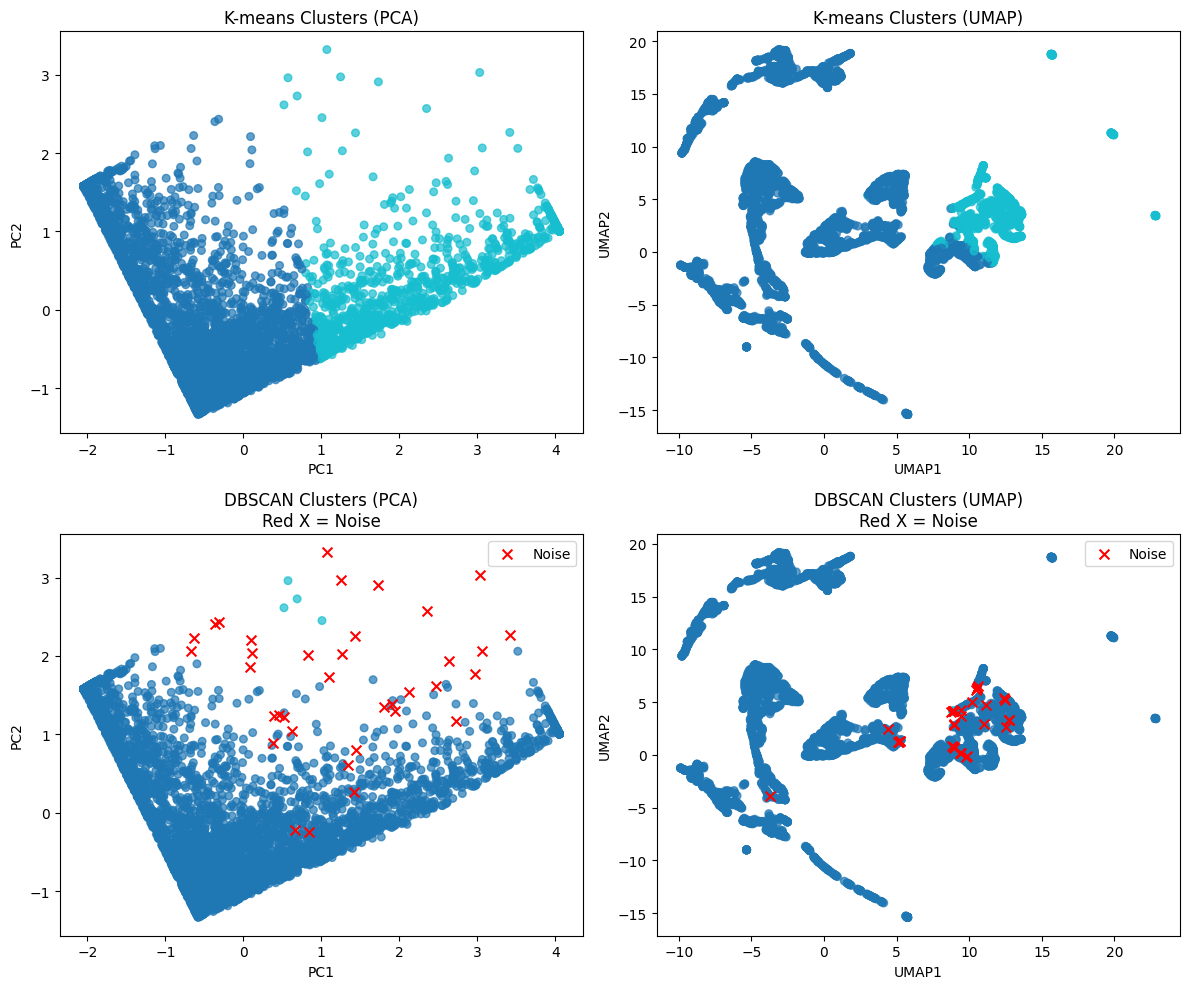

K-means: 2 clusters | DBSCAN: 2 clusters + 36 noise points


In [24]:
# Cluster Visualization
print("Part F: Cluster Visualization")
print("=" * 40)

# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# UMAP Visualization  
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# K-means PCA
axes[0,0].scatter(X_pca[:, 0], X_pca[:, 1], c=rfm_enhanced['KMeans_Cluster'], cmap='tab10', alpha=0.7, s=30)
axes[0,0].set_title('K-means Clusters (PCA)')
axes[0,0].set_xlabel('PC1')
axes[0,0].set_ylabel('PC2')

# K-means UMAP
axes[0,1].scatter(X_umap[:, 0], X_umap[:, 1], c=rfm_enhanced['KMeans_Cluster'], cmap='tab10', alpha=0.7, s=30)
axes[0,1].set_title('K-means Clusters (UMAP)')
axes[0,1].set_xlabel('UMAP1')
axes[0,1].set_ylabel('UMAP2')

# DBSCAN PCA with noise
is_noise = rfm_enhanced['DBSCAN_Cluster'] == -1
axes[1,0].scatter(X_pca[~is_noise, 0], X_pca[~is_noise, 1], c=rfm_enhanced['DBSCAN_Cluster'][~is_noise], cmap='tab10', alpha=0.7, s=30)
axes[1,0].scatter(X_pca[is_noise, 0], X_pca[is_noise, 1], c='red', marker='x', s=50, label='Noise')
axes[1,0].set_title('DBSCAN Clusters (PCA)\nRed X = Noise')
axes[1,0].set_xlabel('PC1')
axes[1,0].set_ylabel('PC2')
axes[1,0].legend()

# DBSCAN UMAP with noise
axes[1,1].scatter(X_umap[~is_noise, 0], X_umap[~is_noise, 1], c=rfm_enhanced['DBSCAN_Cluster'][~is_noise], cmap='tab10', alpha=0.7, s=30)
axes[1,1].scatter(X_umap[is_noise, 0], X_umap[is_noise, 1], c='red', marker='x', s=50, label='Noise')
axes[1,1].set_title('DBSCAN Clusters (UMAP)\nRed X = Noise')
axes[1,1].set_xlabel('UMAP1')
axes[1,1].set_ylabel('UMAP2')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print(f"K-means: {optimal_k} clusters | DBSCAN: {len(set(rfm_enhanced['DBSCAN_Cluster'])) - 1} clusters + {sum(is_noise)} noise points")

In [26]:
# DBSCAN vs K-means Reflection
print("DBSCAN vs K-means: Rare High-Value Customer Detection")
print("=" * 55)

noise_points = rfm_enhanced[rfm_enhanced['DBSCAN_Cluster'] == -1]
high_value_threshold = rfm_enhanced['Orig_Monetary'].quantile(0.75)
high_value_noise = noise_points[noise_points['Orig_Monetary'] > high_value_threshold]

print("\nDBSCAN ADVANTAGES:")
print("• Explicitly identifies outliers as noise points")
print("• Can detect rare high-value customers who don't fit cluster patterns")
print("• No need to pre-specify number of clusters")

print("\nK-MEANS LIMITATIONS:")
print("• Forces all points into clusters, even outliers")
print("• Rare high-value customers get diluted in larger clusters")
print("• Requires specifying k in advance")
print("• Assumes spherical clusters of similar size")



DBSCAN vs K-means: Rare High-Value Customer Detection

DBSCAN ADVANTAGES:
• Explicitly identifies outliers as noise points
• Can detect rare high-value customers who don't fit cluster patterns
• No need to pre-specify number of clusters

K-MEANS LIMITATIONS:
• Forces all points into clusters, even outliers
• Rare high-value customers get diluted in larger clusters
• Requires specifying k in advance
• Assumes spherical clusters of similar size
